## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [20]:
tmp = np.load('../../slides/eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [21]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [22]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [23]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.7088, Test Loss: 0.7170
Epoch 2/200, Loss: 0.5764, Test Loss: 0.6894
Epoch 3/200, Loss: 0.5024, Test Loss: 0.6441
Epoch 4/200, Loss: 0.4574, Test Loss: 0.6130
Epoch 5/200, Loss: 0.4149, Test Loss: 0.5963
Epoch 6/200, Loss: 0.3904, Test Loss: 0.6118
Epoch 7/200, Loss: 0.3796, Test Loss: 0.5595
Epoch 8/200, Loss: 0.3629, Test Loss: 0.5700
Epoch 9/200, Loss: 0.3577, Test Loss: 0.5935
Epoch 10/200, Loss: 0.3588, Test Loss: 0.6061
Epoch 11/200, Loss: 0.3742, Test Loss: 0.5797
Epoch 12/200, Loss: 0.4186, Test Loss: 0.5930
Epoch 13/200, Loss: 0.3729, Test Loss: 0.5709
Epoch 14/200, Loss: 0.3626, Test Loss: 0.5802
Epoch 15/200, Loss: 0.3508, Test Loss: 0.5708
Epoch 16/200, Loss: 0.3456, Test Loss: 0.5645
Epoch 17/200, Loss: 0.3412, Test Loss: 0.5672
Epoch 18/200, Loss: 0.3410, Test Loss: 0.5619
Epoch 19/200, Loss: 0.3406, Test Loss: 0.5552
Epoch 20/200, Loss: 0.3370, Test Loss: 0.5496
Epoch 21/200, Loss: 0.3369, Test Loss: 0.5500
Epoch 22/200, Loss: 0.3380, Test Loss: 0.55

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

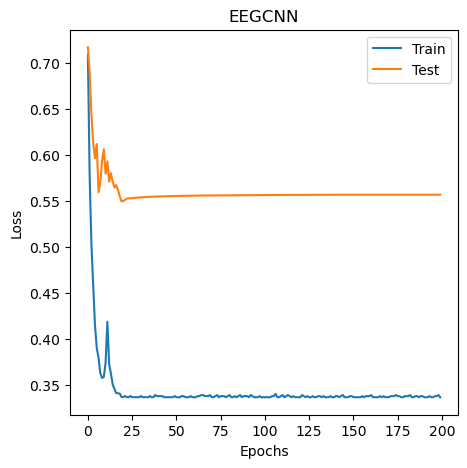

In [25]:
## INSERT CODE HERE
plt.figure(figsize=(5, 5))
plt.plot(range(200), train_losses, label='Train')
plt.plot(range(200), test_losses, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EEGCNN')
plt.show()

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [26]:
## INSERT CODE HERE
print("Minimum train loss: ", min(train_losses))
print("Minimum test loss: ", min(test_losses))

Minimum train loss:  0.33670073250929516
Minimum test loss:  0.5495927731196085


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [27]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOW
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        # INSERT CODE BELOW
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [28]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6783, Test Loss: 0.6691
Epoch 2/200, Loss: 0.5662, Test Loss: 0.6851
Epoch 3/200, Loss: 0.5164, Test Loss: 0.6283
Epoch 4/200, Loss: 0.4861, Test Loss: 0.6466
Epoch 5/200, Loss: 0.4667, Test Loss: 0.5829
Epoch 6/200, Loss: 0.4531, Test Loss: 0.5279
Epoch 7/200, Loss: 0.4232, Test Loss: 0.5477
Epoch 8/200, Loss: 0.4068, Test Loss: 0.5586
Epoch 9/200, Loss: 0.3914, Test Loss: 0.5608
Epoch 10/200, Loss: 0.3785, Test Loss: 0.5317
Epoch 11/200, Loss: 0.3877, Test Loss: 0.5680
Epoch 12/200, Loss: 0.3812, Test Loss: 0.5584
Epoch 13/200, Loss: 0.3798, Test Loss: 0.5274
Epoch 14/200, Loss: 0.3651, Test Loss: 0.5165
Epoch 15/200, Loss: 0.3585, Test Loss: 0.5263
Epoch 16/200, Loss: 0.3499, Test Loss: 0.5038
Epoch 17/200, Loss: 0.3582, Test Loss: 0.5268
Epoch 18/200, Loss: 0.3531, Test Loss: 0.5484
Epoch 19/200, Loss: 0.3468, Test Loss: 0.5086
Epoch 20/200, Loss: 0.3373, Test Loss: 0.5316
Epoch 21/200, Loss: 0.3361, Test Loss: 0.5263
Epoch 22/200, Loss: 0.3443, Test Loss: 0.51

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

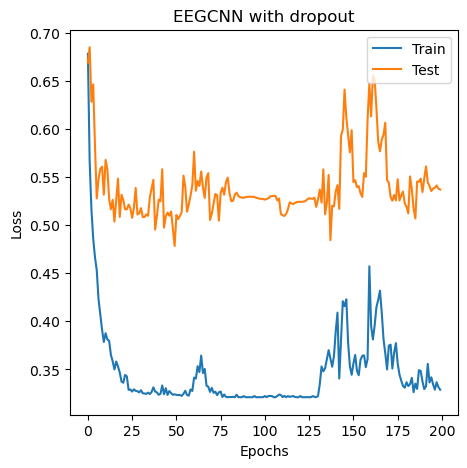

In [29]:
## INSERT CODE HERE
plt.figure(figsize=(5, 5))
plt.plot(range(200), train_losses, label='Train')
plt.plot(range(200), test_losses, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EEGCNN with dropout rate 0.2')
plt.show()

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [30]:
# INSERT CODE HERE
print("Minimum train loss: ", min(train_losses))
print("Minimum test loss: ", min(test_losses))

Minimum train loss:  0.3210761273900668
Minimum test loss:  0.4784154196580251


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [31]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7928, Test Loss: 0.8258
Epoch 2/200, Loss: 0.7706, Test Loss: 0.8179
Epoch 3/200, Loss: 0.7325, Test Loss: 0.6598
Epoch 4/200, Loss: 0.6104, Test Loss: 0.6306
Epoch 5/200, Loss: 0.5582, Test Loss: 0.6191
Epoch 6/200, Loss: 0.5451, Test Loss: 0.5916
Epoch 7/200, Loss: 0.5104, Test Loss: 0.5628
Epoch 8/200, Loss: 0.4877, Test Loss: 0.5496
Epoch 9/200, Loss: 0.4651, Test Loss: 0.5100
Epoch 10/200, Loss: 0.4462, Test Loss: 0.5125
Epoch 11/200, Loss: 0.4353, Test Loss: 0.5270
Epoch 12/200, Loss: 0.4159, Test Loss: 0.5171
Epoch 13/200, Loss: 0.3941, Test Loss: 0.4833
Epoch 14/200, Loss: 0.4024, Test Loss: 0.5103
Epoch 15/200, Loss: 0.4126, Test Loss: 0.4893
Epoch 16/200, Loss: 0.4010, Test Loss: 0.5088
Epoch 17/200, Loss: 0.3825, Test Loss: 0.5080
Epoch 18/200, Loss: 0.3863, Test Loss: 0.4901
Epoch 19/200, Loss: 0.3761, Test Loss: 0.4910
Epoch 20/200, Loss: 0.3578, Test Loss: 0.5170
Epoch 21/200, Loss: 0.3635, Test Loss: 0.4925
Epoch 22/200, Loss: 0.3542, Test Loss: 0.50

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

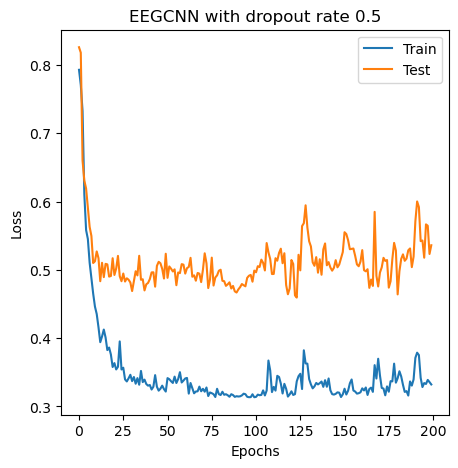

In [32]:
# INSERT CODE HERE
plt.figure(figsize=(5, 5))
plt.plot(range(200), train_losses, label='Train')
plt.plot(range(200), test_losses, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EEGCNN with dropout rate 0.5')
plt.show()

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [33]:
# INSERT CODE HERE
print('Minimum train loss: ', min(train_losses))
print('Minimum test loss: ', min(test_losses))

Minimum train loss:  0.31355072806278866
Minimum test loss:  0.4593844413757324


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7270, Test Loss: 0.7072
Epoch 2/200, Loss: 0.7178, Test Loss: 0.6998
Epoch 3/200, Loss: 0.7442, Test Loss: 0.6933
Epoch 4/200, Loss: 0.7348, Test Loss: 0.6946
Epoch 5/200, Loss: 0.7259, Test Loss: 0.6789
Epoch 6/200, Loss: 0.7421, Test Loss: 0.6642
Epoch 7/200, Loss: 0.6958, Test Loss: 0.6550
Epoch 8/200, Loss: 0.6814, Test Loss: 0.6451
Epoch 9/200, Loss: 0.7010, Test Loss: 0.6280
Epoch 10/200, Loss: 0.6680, Test Loss: 0.6221
Epoch 11/200, Loss: 0.6392, Test Loss: 0.6183
Epoch 12/200, Loss: 0.6534, Test Loss: 0.6148
Epoch 13/200, Loss: 0.6288, Test Loss: 0.6189
Epoch 14/200, Loss: 0.6084, Test Loss: 0.6145
Epoch 15/200, Loss: 0.6435, Test Loss: 0.6077
Epoch 16/200, Loss: 0.6209, Test Loss: 0.6063
Epoch 17/200, Loss: 0.6213, Test Loss: 0.6124
Epoch 18/200, Loss: 0.6071, Test Loss: 0.5979
Epoch 19/200, Loss: 0.5966, Test Loss: 0.6056
Epoch 20/200, Loss: 0.5743, Test Loss: 0.5961
Epoch 21/200, Loss: 0.5610, Test Loss: 0.5928
Epoch 22/200, Loss: 0.5793, Test Loss: 0.59

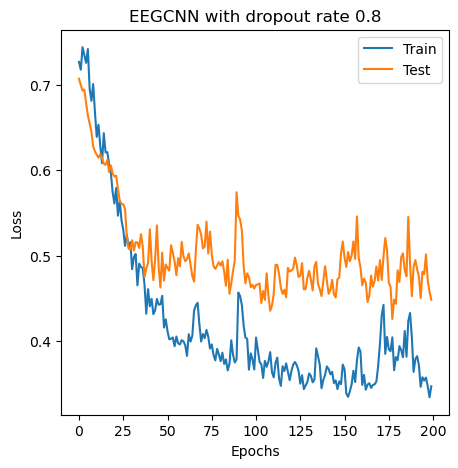

Minimum train loss:  0.33402543266614276
Minimum test loss:  0.42571016152699787


In [34]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)
plt.figure(figsize=(5, 5))
plt.plot(range(200), train_losses, label='Train')
plt.plot(range(200), test_losses, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EEGCNN with dropout rate 0.8')
plt.show()
print('Minimum train loss: ', min(train_losses))
print('Minimum test loss: ', min(test_losses))